In [41]:
import os
import sys
import math
from datetime import datetime
from functools import partial

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from src.models import HED
from src.losses import balanced_cross_entropy
from src.metrics import dice_coefficient, iou, accuracy
from src.dataset import CustomImageDataGenerator, standardize_batch, load_subset
from src.config import *

ELEVATION_TIF_DIR = '/Users/mikeskaug/Documents/personal/ridges/data/high_ridge_terrain/Colorado/manual/tif'
MASK_TIF_DIR = '/Users/mikeskaug/Documents/personal/ridges/data/high_ridge_terrain/Colorado/manual/mask'

In [22]:
def compile_callbacks(
        logs_dir=os.path.join(LOGS_DIR, datetime.now().isoformat(timespec='minutes')), 
        checkpoint_dir=os.path.join(CHECKPOINT_DIR, datetime.now().isoformat(timespec='minutes'))
    ):
    if not os.path.isdir(logs_dir):
        os.mkdir(logs_dir)
    if not os.path.isdir(checkpoint_dir):
        os.mkdir(checkpoint_dir)
    return [
        TensorBoard(
            log_dir=os.path.join(logs_dir),
            histogram_freq=1,
            update_freq='epoch',
            write_graph=False,
            write_images=False,
            profile_batch=0
        ),
        ModelCheckpoint(
            os.path.join(checkpoint_dir, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'), 
            verbose=1,
            save_freq='epoch',
            save_best_only=False, 
            save_weights_only=True
        )
    
    ]

# Load trained model

In [9]:
input_img = Input((*IMAGE_SIZE, 1), name='img')
model = HED(input_img)
model.load_weights('/Users/mikeskaug/Documents/personal/ridges/output/checkpoint/2020-04-24T04:01/weights.02-0.13.hdf5')

# Fine tune on small, manually labeled set

In [10]:
model.compile(loss={'o1': balanced_cross_entropy,
                        'o2': balanced_cross_entropy,
                        'o3': balanced_cross_entropy,
                        'o4': balanced_cross_entropy,
                        'ofuse': balanced_cross_entropy,
                        },
                  metrics={'ofuse': ['accuracy', dice_coefficient]},
                  optimizer=Adam(learning_rate=0.0001))

In [14]:
validation_fraction = 0.3
batch_size = 8
subset = load_subset(ELEVATION_TIF_DIR, frac=1)
featurewise_std = subset.std()

files = os.listdir(ELEVATION_TIF_DIR)
np.random.shuffle(files)
train_files = files[:int(len(files)*(1-validation_fraction))]
validation_files = files[int(len(files)*(1-validation_fraction)):]

training_generator = CustomImageDataGenerator(
    ELEVATION_TIF_DIR, 
    MASK_TIF_DIR, 
    train_files, 
    batch_size=batch_size, 
    standardize_batch=partial(standardize_batch, featurewise_std), 
    rescale_y=1/255,
    n_outputs=5
)

validation_generator = CustomImageDataGenerator(
    ELEVATION_TIF_DIR, 
    MASK_TIF_DIR, 
    validation_files, 
    batch_size=len(validation_files)*8, 
    standardize_batch=partial(standardize_batch, featurewise_std), 
    rescale_y=1/255,
    n_outputs=5
)
validation_data = validation_generator.__getitem__(0)

In [26]:
training_history = model.fit(
    training_generator,
    steps_per_epoch=len(training_generator),
    epochs=50,
    callbacks=compile_callbacks(),
    shuffle=False,
    validation_data=validation_data
)

Train for 7 steps, validate on 24 samples
Epoch 1/50
6/7 [========================>.....] - ETA: 7s - loss: 0.1638 - o1_loss: 0.0386 - o2_loss: 0.0311 - o3_loss: 0.0293 - o4_loss: 0.0358 - ofuse_loss: 0.0289 - ofuse_accuracy: 0.9008 - ofuse_dice_coefficient: 0.3137 
Epoch 00001: saving model to /Users/mikeskaug/Documents/personal/ridges/output/checkpoint/2020-06-18T21:32/weights.01-0.10.hdf5
7/7 [==============================] - 60s 9s/step - loss: 0.1630 - o1_loss: 0.0383 - o2_loss: 0.0310 - o3_loss: 0.0291 - o4_loss: 0.0356 - ofuse_loss: 0.0288 - ofuse_accuracy: 0.9022 - ofuse_dice_coefficient: 0.3190 - val_loss: 0.0981 - val_o1_loss: 0.0231 - val_o2_loss: 0.0171 - val_o3_loss: 0.0187 - val_o4_loss: 0.0223 - val_ofuse_loss: 0.0167 - val_ofuse_accuracy: 0.9382 - val_ofuse_dice_coefficient: 0.3375
Epoch 2/50
6/7 [========================>.....] - ETA: 7s - loss: 0.1431 - o1_loss: 0.0358 - o2_loss: 0.0262 - o3_loss: 0.0249 - o4_loss: 0.0319 - ofuse_loss: 0.0241 - ofuse_accuracy: 0.9181

# Evaluate

In [31]:
predict_batch = validation_data[0]
masks = validation_data[1][0]
predictions = model.predict_on_batch(predict_batch)

In [46]:
x = iou(masks, tf.cast(predictions[-1] > 0.987, tf.float64))
print(f'IOU: {x}')

float64 <dtype: 'float64'>
IOU: 0.0035934981192907037


Best threshold: 0.8061224489795917, IOU: 0.39001388017416766


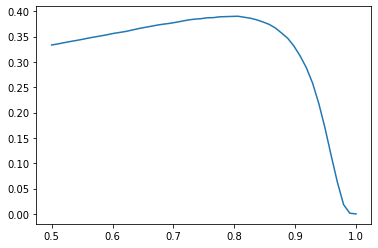

In [55]:
thresholds = np.linspace(0.5, 1)
iou_vals = [iou(masks, tf.cast(predictions[-1] > thresh, tf.float64)).numpy() for thresh in thresholds]
sns.lineplot(thresholds, iou_vals)
print(f'Best threshold: {thresholds[np.argmax(iou_vals)]}, IOU: {max(iou_vals)}')

# Evaluate heuristic model

In [56]:
from src.transforms import ridges

In [73]:
generator = CustomImageDataGenerator(
    ELEVATION_TIF_DIR, 
    MASK_TIF_DIR, 
    validation_files, 
    batch_size=len(validation_files)*8, 
    rescale_y=1/255,
    n_outputs=1
)
test_data = generator.__getitem__(0)

In [74]:
heuristic_pred = np.zeros(test_data[0].shape[:-1])
for sample_id in range(test_data[0].shape[0]):
    heuristic_pred[sample_id] = ridges(np.squeeze(test_data[0][sample_id])).astype(float)

In [75]:
accuracy(masks, heuristic_pred[:, :, :, np.newaxis])

<tf.Tensor: id=56990, shape=(), dtype=float64, numpy=0.961944580078125>

In [76]:
x = iou(masks, heuristic_pred[:, :, :, np.newaxis])
print(f'IOU: {x}')

IOU: 0.30709390627894056


# Compare examples

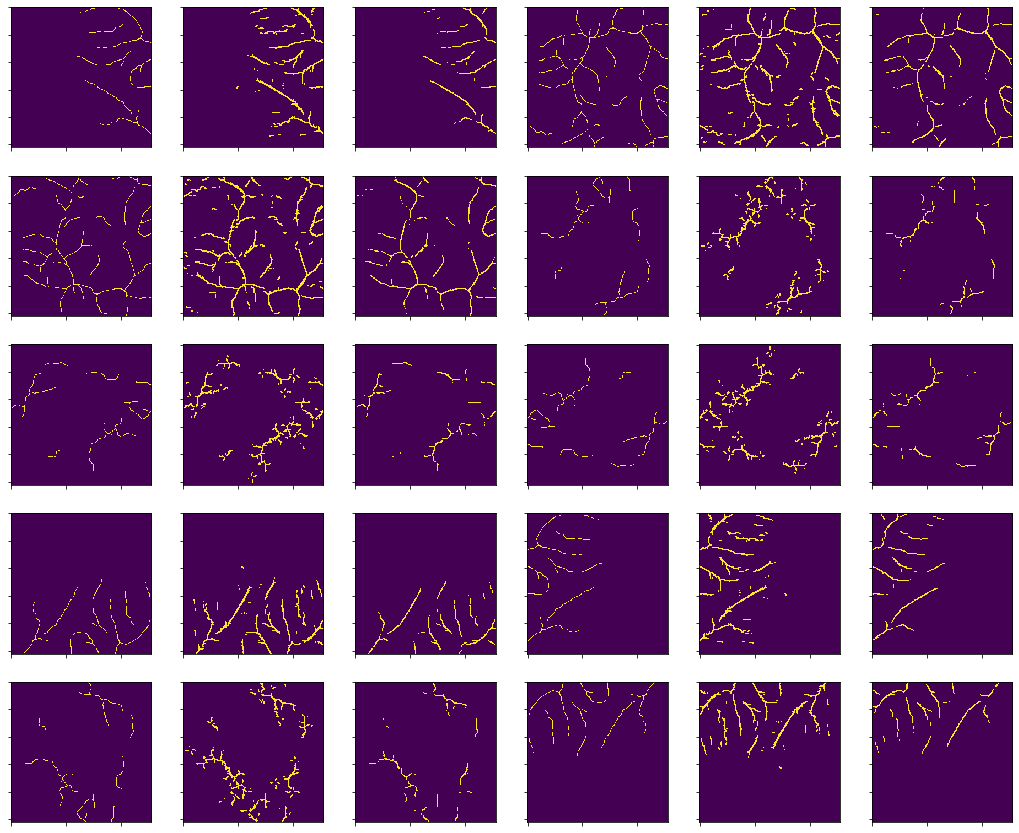

In [77]:
all_images = np.empty((30,256,256), dtype='float32')
all_images[0::3,:,:] = np.squeeze(masks[:10])
all_images[1::3,:,:] = heuristic_pred[:10]
all_images[2::3,:,:] = np.squeeze(predictions[-1][:10]) > 0.806

grid_width = 6
grid_height = int(all_images.shape[0] / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(18, 15))
for i in range(grid_height*grid_width):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow((all_images[i, :, :].reshape((256, 256))), cmap='viridis', ) #vmin=0, # coolwarm
    ax.set_yticklabels([])
    ax.set_xticklabels([])